In [1]:
import os
import warnings
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings(action="ignore")
%matplotlib inline

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
# Define file paths
healthy_dirs = [
    'test/NORMAL',
    'train/NORMAL',
    'val/NORMAL',
]

pneumonia_dir = [ 
    'test/PNEUMONIA',
    'train/PNEUMONIA',
    'val/PNEUMONIA',
]

In [3]:
filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                       filepaths  labels
0  test/NORMAL\IM-0001-0001.jpeg  Normal
1  test/NORMAL\IM-0003-0001.jpeg  Normal
2  test/NORMAL\IM-0005-0001.jpeg  Normal
3  test/NORMAL\IM-0006-0001.jpeg  Normal
4  test/NORMAL\IM-0007-0001.jpeg  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [4]:
pneumonia_df.shape

(5856, 2)

In [5]:
# Augmentation setup for normal images
normal_image_paths = pneumonia_df[pneumonia_df['labels'] == 'Normal']['filepaths'].tolist()
augmented_image_path = 'augmented/NORMAL/'  # Folder to save augmented images
os.makedirs(augmented_image_path, exist_ok=True)

# Define ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to save augmented images
def augment_image(image_path, save_dir, save_prefix, save_format='jpeg', n_copies=5):
    img = load_img(image_path)  # Load image
    x = img_to_array(img)  # Convert image to array
    x = x.reshape((1,) + x.shape)  # Reshape for ImageDataGenerator

    # Generate and save augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format=save_format):
        i += 1
        if i >= n_copies:
            break

In [6]:
# Apply augmentation to the normal images
#for img_path in normal_image_paths:
   # img_name = os.path.basename(img_path).split('.')[0]
   # augment_image(img_path, augmented_image_path, img_name)

In [7]:
# Print the number of augmented images generated
augmented_images = os.listdir(augmented_image_path)
print(f"Number of augmented images generated: {len(augmented_images)}")

Number of augmented images generated: 7912


In [8]:
# Load augmented images and add to the original dataset
augmented_filepaths = [os.path.join(augmented_image_path, img) for img in os.listdir(augmented_image_path)]
augmented_labels = ['Normal'] * len(augmented_filepaths)

# Create a new DataFrame for augmented images
augmented_Fseries = pd.Series(augmented_filepaths, name="filepaths")
augmented_Lseries = pd.Series(augmented_labels, name="labels")
augmented_data = pd.concat([augmented_Fseries, augmented_Lseries], axis=1)

# Append augmented data to the original dataset
updated_pneumonia_df = pd.concat([pneumonia_df, augmented_data], ignore_index=True)

# Shuffle the updated DataFrame to mix augmented and original data
updated_pneumonia_df = updated_pneumonia_df.sample(frac=1).reset_index(drop=True)

print(updated_pneumonia_df.head())
print(updated_pneumonia_df["labels"].value_counts())

                                        filepaths     labels
0    train/PNEUMONIA\person515_bacteria_2188.jpeg  Pneumonia
1   train/PNEUMONIA\person1129_bacteria_3070.jpeg  Pneumonia
2   train/PNEUMONIA\person1670_bacteria_4431.jpeg  Pneumonia
3       train/PNEUMONIA\person768_virus_1396.jpeg  Pneumonia
4  augmented/NORMAL/IM-0523-0001-0001_0_4759.jpeg     Normal
labels
Normal       9495
Pneumonia    4273
Name: count, dtype: int64


In [9]:
# First split into train + validation (80%) and test set (20%)
train_val_df, test_df = train_test_split(updated_pneumonia_df, test_size=0.15, stratify=updated_pneumonia_df['labels'])

# Now split train + validation into training set (80% of 80%) and validation set (20% of 80%)
train_df, val_df = train_test_split(train_val_df, test_size=0.175, stratify=train_val_df['labels'])

print(train_df.shape)
#print(train_set.shape)
print(test_df.shape)
#print(test_set.shape)
print(val_df.shape)
#print(val_set.shape)

(9654, 2)
(2066, 2)
(2048, 2)


In [10]:
# Define ImageDataGenerator for training (with real-time augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for validation (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Test set should not be shuffled
)

Found 9654 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.


In [11]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 9654 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.


In [12]:
classes=list(train_generator.class_indices.keys())
print (classes)


def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

['Normal', 'Pneumonia']


In [13]:
from tensorflow.keras.applications import MobileNetV2

def mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet = mobilenet_model()
mobilenet.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [14]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', # You can also use 'val_accuracy' depending on your goal
                               patience=3,        # Number of epochs to wait after no improvement
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
                               verbose=1)

In [15]:
# Fit the model with early stopping
history = mobilenet.fit(train,
                    validation_data=val,
                    epochs=7,   # You can set a high number, early stopping will stop earlier if there's no improvement
                    callbacks=[early_stopping],  # Pass early stopping in the callbacks list
                    verbose=1)

Epoch 1/7
2414/2414 [==============================] - 4542s 2s/step - loss: 0.2768 - accuracy: 0.8998 - val_loss: 0.6961 - val_accuracy: 0.8110
Epoch 2/7
2414/2414 [==============================] - 5004s 2s/step - loss: 0.1292 - accuracy: 0.9565 - val_loss: 6.3984 - val_accuracy: 0.6895
Epoch 3/7
2414/2414 [==============================] - 4981s 2s/step - loss: 0.1027 - accuracy: 0.9636 - val_loss: 2.2225 - val_accuracy: 0.7710
Epoch 4/7
2414/2414 [==============================] - 26957s 11s/step - loss: 0.0919 - accuracy: 0.9684 - val_loss: 0.2440 - val_accuracy: 0.9546
Epoch 5/7
2414/2414 [==============================] - 5101s 2s/step - loss: 0.0877 - accuracy: 0.9717 - val_loss: 0.4876 - val_accuracy: 0.8979
Epoch 6/7
2414/2414 [==============================] - 5058s 2s/step - loss: 0.0652 - accuracy: 0.9793 - val_loss: 0.2666 - val_accuracy: 0.9673
Epoch 7/7
2414/2414 [==============================] - 5123s 2s/step - loss: 0.0607 - accuracy: 0.9782 - val_loss: 0.1472 - val_

In [17]:
mobilenet.evaluate(test, verbose=1)

517/517 [==============================] - 363s 701ms/step - loss: 0.1542 - accuracy: 0.9729


[0.15424488484859467, 0.9728944897651672]

In [19]:
mobilenet.save("pneumonia_Model.h5")
pred = mobilenet.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

517/517 [==============================] - 352s 665ms/step


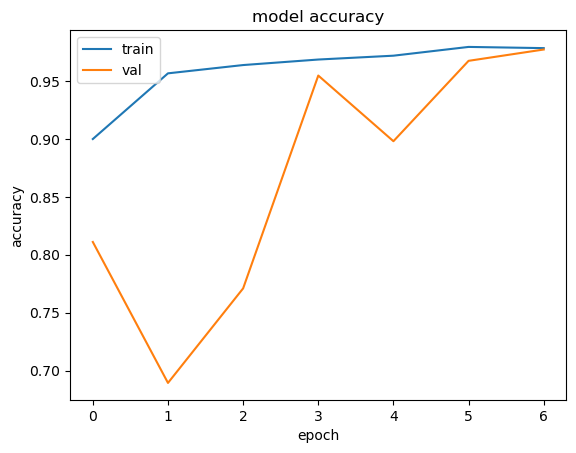

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

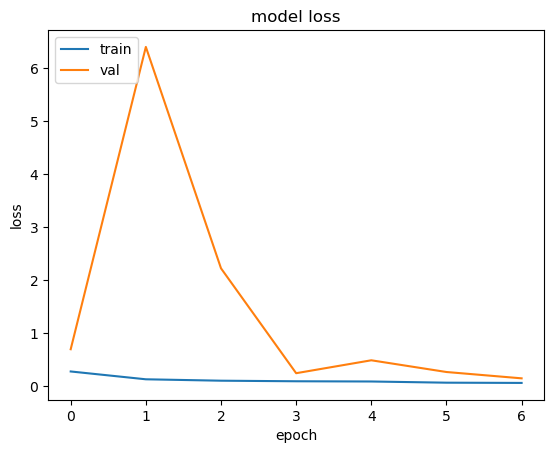

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_test = test_df.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      1425
   Pneumonia       0.94      0.98      0.96       641

    accuracy                           0.97      2066
   macro avg       0.96      0.97      0.97      2066
weighted avg       0.97      0.97      0.97      2066

Accuracy of the Model: 97.3%


In [23]:
cm = confusion_matrix(y_test, pred2)
print(cm)

[[1385   40]
 [  16  625]]
